# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

### Imports and Weights and Biases login
Main imports to run the code. Installation, login and eventually update of wandb.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

# Tracking experiments
import wandb
wandb.login()

wandb: Currently logged in as: niccolo-arati (dla-labs). Use `wandb login --relogin` to force relogin


True

### Policy Network
A simple policy network with one hidden layer. A temperature parameter could be specified to smooth the output (default value is 1, which leads to no changes).

In [2]:
def temperature_scaled_softmax(logits, temperature):
    logits = logits / temperature
    return F.softmax(logits, dim=-1)

# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env, inner_size = 128, T=1.0):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, env.action_space.n)
        self.relu = nn.ReLU()
        self.temperature = T

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = temperature_scaled_softmax(self.fc2(s), self.temperature)
        return s

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here.

### Reinforce
I decided to define a wrapper class for executing the REINFORCE policy gradient algorithm. This class will also be used as root for a class inheritance hierarchy, extending Reinforce to add the new functionalities required by the notebook.

As attributes, it requires a policy network, the environment to train the policy network, eventually an environment with rendering to show intermediate results, and some training hyperparameters:

1. gamma: used to compute discounted total reward, balances the importance of immediate versus future reward. A higher value gives a higher weight to future rewards while a lower value prioritizes immediate rewards.
2. num_episodes: number of episodes to train the policy network
3. lr: learning rate
4. max_len: maximum length of a single episode

The methods of the class are used to select actions (select_action and select_max_action) and run an episode in the environment (run_episode), as well as to execute the REINFORCE algorithm (reinforce).

In [7]:
class Reinforce:
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len = 500):
        self.policy = policy
        self.environment = env
        self.env_render = env_render
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.learning_rate = lr
        self.max_len = max_len # Max length for each episode

    # Given an environment, observation, and policy, sample from pi(a | obs). Returns the
    # selected action and the log probability of that action (needed for policy gradient).
    def select_action(self, obs):
        dist = Categorical(self.policy(obs))
        action = dist.sample() 
        log_prob = dist.log_prob(action)
        return (action.item(), log_prob.reshape(1))

    # Used for testing, select the most probabile action given the policy and the current observation.
    def select_max_action(self, obs):
        probs = self.policy(obs)
        action = torch.argmax(probs)
        log_prob = torch.log(torch.max(probs))
        return(action.item(), log_prob.reshape(1))

    # Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
    # .copy() the final numpy array.
    def compute_returns(self, rewards):
        return np.flip(np.cumsum([self.gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

    # Sets an environment with rendering to display final results
    def setEnvRender(self, env_render):
        self.env_render = env_render

    # Given an environment and a policy, run it up to the maximum number of steps.
    # If test is True, then the action is selected with the deterministic way
    def run_episode(self, display=False, test=False):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        env = self.environment
        if display:
            env = self.env_render

        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(self.max_len):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            if test:
                (action, log_prob) = self.select_max_action(obs)
            else:
                (action, log_prob) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        return (observations, actions, torch.cat(log_probs), rewards)

    # Implementation of the REINFORCE policy gradient algorithm. It does not require any argument, because the
    # parameters needed to run the algorithm are wrapped within the class as attributes.
    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # Track episode rewards in a list.
        running_rewards = [0.0]

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0].item() + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Standardize returns.
            returns = (returns - returns.mean()) / returns.std()

            # Make an optimization step
            opt.zero_grad()
            loss = (-log_probs * returns).mean()
            loss.backward()
            opt.step()

            metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
            wandb.log({**metrics}) 

            # Render an episode after every 100 policy updates.
            if not episode % 100:
                self.policy.eval()
                (obs, _, _, _) = self.run_episode(display=True)
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        return (running_rewards)

### Runs of REINFORCE
Once an object of the Reinforce class is instantiated, running the reinforce method trains the policy network on Cartpole environment. For subsequent testing, 20 episodes are executed by selecting actions with the highest probability, according to the last policy network trained. The average reward for each episode is observed.

The hyperparameters have been choosen empirically (mainly temperature, gamma and hidden layer size), I will not report runs that I used to decide their values. Since training the policy is stochastic, for each setting I performed the policy training 5 times, and then in the reports I reported the metrics of interest in a graphic with mean curve and standard variance.

These guidelines remain valid for the subsequent runs with the updated versions of REINFORCE.

In [ ]:
# Your code here. You should be able to train an agent to solve Cartpole. This will be our starting point.

n_run = 5
seeds = [11, 111, 1111, 11111, 111111]
val_seeds = [22, 222, 22222, 22222, 222222]

for i in range(n_run):

    # Instantiate a rendering and a non rendering environment
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    # Track run
    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Submission",
          # Pass a run name
          name=f"Reinforce",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "architecture": "REINFORCE",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "temperature": 20})

    # Make a policy network.
    policy = PolicyNet(env, T=run.config["temperature"]) # Hidden layer size: 128

    # Train the agent.
    r = Reinforce(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"])
    (rewards) = r.reinforce()
    #plt.plot(rewards)

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [9]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards) = r.run_episode(display=True, test=True) # Deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

Average reward for episode: 500.0


### wandb Reinforce Report
https://wandb.ai/dla-labs/Lab3-Submission/reports/Reinforce-Report--Vmlldzo5MTQ5OTYx

Observing the graphs, we notice that with temperature=20 and gamma=0.99 the training is extremely stable. The loss rarely deviates from 0, while the running reward stabilizes at high values after the first few episodes. The gamma value indicates the importance of future steps for the Cartpole environment.

Empirically I saw that the temperature could have been lowered to achieve even greater stability, but I chose to keep it at 20 to avoid an overly optimal configuration, especially since gamma is still the more impactful parameter of the two.

From the testing, we observe that each episode achieved the maximum reward, indicating that the training was successful.

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

### ReinforceAvg
The class extends Reinforce and implements the requirements mentioned above.
Two attributes have been added: N and eval_episodes.
The methods run_episode and reinforce have been overridden to implement the new required functionalities.

In [10]:
class ReinforceAvg(Reinforce):
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len=500, N=100, eval_episodes=10):
        super().__init__(policy, env, env_render, gamma, num_episodes, lr, max_len)
        self.N = N
        self.M = eval_episodes

    # Override to collect also episode length
    def run_episode(self, display=False, test=False):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        env = self.environment
        if display:
            env = self.env_render

        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(self.max_len):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            if test:
                (action,log_prob) = self.select_max_action(obs)
            else:
                (action, log_prob) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        length = i + 1
        return (observations, actions, torch.cat(log_probs), rewards, length)

    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # Track episode rewards, average rewards and average episode lengths in 3 lists.
        running_rewards = [0.0]
        average_rewards = []
        average_lengths = []

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards, length) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0].item() + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Standardize returns.
            returns = (returns - returns.mean()) / returns.std()

            # Make an optimization step
            opt.zero_grad()
            loss = (-log_probs * returns).mean()
            loss.backward()
            opt.step()

            metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
            wandb.log({**metrics})

            # Render M episodes after every N policy updates.
            if not episode % self.N:
                self.policy.eval()
                total_reward = 0
                total_length = 0
                for _ in range(self.M):
                    (_, _, _, rewards, length) = self.run_episode()
                    total_reward += np.sum(rewards)
                    total_length += length
                average_reward = total_reward / self.M
                average_rewards.append(average_reward)
                print(f'Average Total: {average_reward}')
                average_length = total_length / self.M
                average_lengths.append(average_length)
                print(f'Average Length: {average_length}')

                val_metrics = {"Average Total Reward": average_reward,
                               "Average Length": average_length}
                wandb.log({**val_metrics})

                (obs, _, _, _, _) = self.run_episode(display=True)
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        return (running_rewards, average_rewards, average_lengths)

### Runs of ReinforceAvg

In [ ]:
for i in range(n_run):

    # Instantiate a rendering and a non rendering environment
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Final",
          # Pass a run name
          name=f"ReinforceAvg",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "architecture": "REINFORCE_AVG",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "N": 100,
          "temperature": 20,
          "M": 10})
    
    # Make a policy network.
    policy = PolicyNet(env, T=run.config["temperature"])

    # Train the agent.
    r = ReinforceAvg(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"],
                     N=run.config["N"], eval_episodes=run.config["M"])
    (total, average, length) = r.reinforce()

    #plt.plot(total)
    #plt.title('Average Discounted Rewards')
    #plt.figure()
    #plt.plot(average)
    #plt.title('Average Total Rewards')
    #plt.figure()
    #plt.plot(length)
    #plt.title('Average Episode Length')
    #plt.figure()

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [13]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards, _) = r.run_episode(display=True, test=True) # Deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

Average reward for episode: 500.0


### wandb ReinforceAvg Report
https://wandb.ai/dla-labs/Lab3-Final/reports/ReinforceAvg-Report--Vmlldzo5MTUwMDU5

The two new metrics, average total reward and average total length, are identical because in the Cartpole environment the reward is increased by one for each step taken in the episode. Therefore, the total reward for each individual episode is equal to the episode's length.

Looking at the average total reward, we notice that after the first few episodes, the curve stabilizes around 500 (the maximum value, as I set the maximum episode length to 500), except for a slight dip in the last episodes. This further confirms that the training was successful.

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

### ReinforceStd
This class extends ReinforceAvg. 
The attribute baseline has been added to specify whether we want no baseline or a standardization baseline.
The method reinforce has been overridden to implement the distinction between standardization and no baseline.

In [14]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.

class ReinforceStd(ReinforceAvg):
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len=500, N=100, eval_episodes=10, baseline=None):
        super().__init__(policy, env, env_render, gamma, num_episodes, lr, max_len, N, eval_episodes)
        self.baseline = baseline

    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # Choose between standardization baseline or no baseline
        if self.baseline == 'std':
            print('Training agent with standardization baseline.')
        else:
            print('Training agent with no baseline.')

        # Track episode rewards, average rewards and average lengths in 3 lists.
        running_rewards = [0.0]
        average_rewards = []
        average_lengths = []

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards, length) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0].item() + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Handle baseline.
            if self.baseline == 'std':
                target = (returns - returns.mean()) / returns.std()
            else:
                target = returns

            # Make an optimization step
            opt.zero_grad()

            # Update policy network
            loss = (-log_probs * target).mean()
            loss.backward()
            opt.step()

            metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
            wandb.log({**metrics})

            # Render an episode after every 100 policy updates.
            if not episode % self.N:
                self.policy.eval()
                total_reward = 0
                total_length = 0
                for _ in range(self.M):
                    (_, _, _, rewards, length) = self.run_episode(display=True)
                    total_reward += np.sum(rewards)
                    total_length += length
                average_reward = total_reward / self.M
                average_rewards.append(average_reward)
                print(f'Average Total: {average_reward}')
                average_length = total_length / self.M
                average_lengths.append(average_length)
                print(f'Average Length: {average_length}')

                val_metrics = {"Average Total Reward": average_reward,
                               "Average Length": average_length}
                wandb.log({**val_metrics})

                (obs, _, _, _, _) = self.run_episode()
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        return (running_rewards, average_rewards, average_lengths)

### ReinforceStd runs
The expectations are that without the standardization baseline, the training will be less stable.

In [ ]:
for i in range(n_run):

    # Instantiate a rendering and a non-rendering environment.
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Submission",
          # Pass a run name
          name=f"ReinforceStd",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "architecture": "REINFORCE_STD",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "N": 100,
          "temperature": 20,
          "M": 10,
          "baseline": None})
    
    # Make a policy network.
    policy = PolicyNet(env, T=run.config["temperature"])

    # Train the agent.
    r = ReinforceStd(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"],
                     N=run.config["N"], eval_episodes=run.config["M"], baseline=run.config["baseline"])
    (total, average, length) = r.reinforce()

    #plt.plot(total)
    #plt.title('Average Discounted Rewards')
    #plt.figure()
    #plt.plot(average)
    #plt.title('Average Total Rewards')
    #plt.figure()
    #plt.plot(length)
    #plt.title('Average Episode Length')
    #plt.figure()

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [17]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards, _) = r.run_episode(display=True, test=True) # Deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

Average reward for episode: 427.8


### wandb ReinfoceStd Report
https://wandb.ai/dla-labs/Lab3-Submission/reports/ReinforceStd-Report--Vmlldzo5MTQ5OTkx

As expected, the training is much more unstable without the standardization baseline. For example, the average total reward rarely approaches the maximum value of 500, and when it does, it's only in the final episodes. Meanwhile, the loss remains relatively high, especially when compared to the Reinforce version with the standardization baseline (with the same hyperparameters configuration).

The growth of the running reward is much slower and more irregular, and the fact that the agent received worse training is also confirmed by the evaluation results.

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

### Baseline Network
A simple network with the same architecture as the Policy Net that has to learn to estimate the value function.

In [18]:
class BaselineNet(nn.Module):
    def __init__(self, env, inner_size=128):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, 1)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

### ReinfoceBas
The class extends ReinforceStd. Since we are now also considering baselines that can be neural networks, an additional attribute, lrb, has been added to indicate the learning rate of the Baseline Network. The methods select_action, run_episode and reinforce have been overridden to implement the eventual usage of a Baseline Network.

If there is a baseline, the policy loss, that is used to optimize the policy, is calculated with the target value. If the baseline is a Neural Network it is also optimized using its loss (how closely it approximates the value function).

In [26]:
class ReinforceBas(ReinforceStd):
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len=500, N=100, eval_episodes=10, baseline=None, lrb=1e-2):
        super().__init__(policy, env, env_render, gamma, num_episodes, lr, 
                         max_len, N, eval_episodes, baseline)
        self.learning_rate_baseline = lrb

    def select_action(self, obs):
        value = self.baseline(obs)
        value.compute_grad = True
        dist = Categorical(self.policy(obs))
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return (action.item(), log_prob.reshape(1), value)

    def select_max_action(self, obs):
        value = self.baseline(obs)
        value.compute_grad = True
        probs = self.policy(obs)
        action = torch.argmax(probs)
        log_prob = torch.log(torch.max(probs))
        return(action.item(), log_prob.reshape(1), value)

    # Given an environment and a policy, run it up to the maximum number of steps.
    def run_episode(self, display=False, test=False):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        values = []
        env = self.environment
        if display:
            env = self.env_render

        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(self.max_len):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            if test:
                (action, log_prob, value) = self.select_max_action(obs)
            else:
                (action, log_prob, value) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)
            values.append(value)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        length = i + 1
        return (observations, actions, torch.cat(log_probs), rewards, length, values)

    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # If we have a baseline network, create the optimizer.
        if isinstance(self.baseline, nn.Module):
            opt_baseline = torch.optim.Adam(self.baseline.parameters(), lr=self.learning_rate_baseline)
            self.baseline.train()
            print('Training agent with baseline value network.')
        elif self.baseline == 'std':
            print('Training agent with standardization baseline.')
        else:
            print('Training agent with no baseline.')

        # Track episode rewards, average rewards and average episode lengths in 3 lists.
        running_rewards = [0.0]
        average_rewards = []
        average_lengths = []

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards, length, values) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)
            values =  torch.cat(values)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0] + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Handle baseline.
            if isinstance(self.baseline, nn.Module):
                with torch.no_grad():
                    target = returns - values
            elif self.baseline == 'std':
                target = (returns - returns.mean()) / returns.std()
            else:
                target = returns

            # Make an optimization step
            opt.zero_grad()

            # Update policy network
            loss = (-log_probs * target).mean()
            loss.backward()
            opt.step()

            # Update baseline network.
            if isinstance(self.baseline, nn.Module):
                loss_baseline = F.mse_loss(values, returns)
                opt_baseline.zero_grad()
                loss_baseline.backward()
                opt_baseline.step()

                metrics = {"Policy Loss": loss,
                           "Running Reward": running_reward,
                           "Baseline Loss": loss_baseline}
            else:
              metrics = {"Policy Loss": loss,
                         "Running Reward": running_reward}

            wandb.log({**metrics})

            # Render an episode after every 100 policy updates.
            if not episode % self.N:
                self.policy.eval()
                total_reward = 0
                total_length = 0
                for _ in range(self.M):
                    (_, _, _, rewards, length, values) = self.run_episode()
                    total_reward += np.sum(rewards)
                    total_length += length
                average_reward = total_reward / self.M
                average_rewards.append(average_reward)
                print(f'Average Total: {average_reward}')
                average_length = total_length / self.M
                average_lengths.append(average_length)
                print(f'Average Length: {average_length}')

                val_metrics = {"Average Total Reward": average_reward,
                               "Average Length": average_length}
                wandb.log({**val_metrics})

                (obs, _, _, _, _, _) = self.run_episode(display=True)
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        if isinstance(self.baseline, nn.Module):
            self.baseline.eval()
        return (running_rewards, average_rewards, average_lengths)

### ReinforceBas runs

In [ ]:
n_run = 5
seeds = [11, 111, 1111, 11111, 111111]
val_seeds = [22, 222, 22222, 22222, 222222]

for i in range(n_run):

    # Instantiate a rendering and a non-rendering environment.
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Submission",
          # Pass a run name
          name=f"ReinforceBas",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "baaseline_learning_rate":1e-2,
          "architecture": "REINFORCE_BAS",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "N": 100,
          "temperature": 20,
          "M": 10,
          "baseline": "BaselineNet",
          "learning_rate_baseline": 1e-2})

    # Make a policy and a baseline network.
    policy = PolicyNet(env, T=run.config["temperature"])
    baseline = BaselineNet(env)

    # Train the agent.
    r = ReinforceBas(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"],
                     N=run.config["N"], eval_episodes=run.config["M"], baseline=baseline,
                     lrb=run.config["learning_rate_baseline"])
    (total, average, length) = r.reinforce()

    #plt.plot(total)
    #plt.title('Average Discounted Rewards')
    #plt.figure()
    #plt.plot(average)
    #plt.title('Average Total Rewards')
    #plt.figure()
    #plt.plot(length)
    #plt.title('Average Episode Length')
    #plt.figure()

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [28]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards, _, _) = r.run_episode(display=True, test=True) # Deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

Average reward for episode: 470.8


### wandb ReinforceBas Report
https://wandb.ai/dla-labs/Lab3-Submission/reports/ReinforceBas-Report--Vmlldzo5MTUyOTM1

Observing the graphs, we notice that training with the baseline net is effective, although convergence appears slower compared to the standardization baseline. This conclusion is supported not only by a direct comparison of the graphs but also by the baseline loss graph, which seems to stabilize at lower values in the final episodes. 

This hypothesis is further confirmed by the testing results, where the average reward is 470. While this is better than not using a baseline, it still doesn't match the level of the standardization baseline. With longer training, the results would likely be even more comparable.

Another possible explanation for the slower convergence could be the simplicity (the standardized mean of the discounted return seems like a very good approximation of the value function) of the problem since its convergence is incredibly fast and stable.

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.


Some other needed imports to run the code:

In [3]:
#Excercise 3.2

import random
from tqdm import trange
from collections import namedtuple, deque

device = "cpu"

### DQN
A Neural Network that takes in n_observations and tries to predict the expected return of taking each possible action given the current input.

In [4]:
class DQNet(nn.Module):
    def __init__(self, n_obs, n_actions, inner_size=64):
        super(DQNet, self).__init__()
        self.layer1 = nn.Linear(n_obs, inner_size)
        self.layer2 = nn.Linear(inner_size, inner_size)
        self.layer3 = nn.Linear(inner_size, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Replay Buffer
It stores the transitions (observation, action, reward, next_state, done) that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated.

In [5]:
class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.transition = namedtuple("Transition", 
                                     field_names=["observation", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, observation, action, reward, next_state, done):
        t = self.transition(observation, action, reward, next_state, done)
        self.memory.append(t)

    def sample(self):
        # Sample batch_size random transitions
        transitions = random.sample(self.memory, k=self.batch_size)

        observations = torch.from_numpy(np.vstack([t.observation for t in transitions if t is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([t.action for t in transitions if t is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([t.reward for t in transitions if t is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([t.next_state for t in transitions if t is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([t.done for t in transitions if t is not None]).astype(np.uint8)).float().to(device)

        return (observations, actions, rewards, next_states, dones)

### DQN Agent
* getAction() takes in input a state and a value for epsilon, it outputs an action by following an epsilon greedy policy.

* save2memory() adds the current transition to the memory buffer, every learn_step transitions it calls the method learn.

* learn() takes in input a batch from replay buffer and trains the DQN agent with MSE loss using temporal difference, Deep Q Learning.

* softUpdate() updates the target network (the update depends on tau parameter)

In [6]:
class DQN():
    def __init__(self, n_obs, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step # Interval to update net_target
        self.tau = tau

        # Model
        self.net_policy = DQNet(n_obs, n_actions).to(device)
        self.net_target = DQNet(n_obs, n_actions).to(device)
        self.net_target.load_state_dict(self.net_policy.state_dict())
        self.optimizer = optim.Adam(self.net_policy.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # Memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0 # Reset cycle counter

    def getAction(self, observation, epsilon):
        observation = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        self.net_policy.eval()
        with torch.no_grad():
            action_values = self.net_policy(observation)
        self.net_policy.train()

        # Epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, observation, action, reward, next_state, done):
        self.memory.add(observation, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                transitions = self.memory.sample()
                self.learn(transitions)
                # Until batch_size actions are not done, learning  will not start

    def learn(self, transitions):
        observations, actions, rewards, next_states, dones = transitions

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones) # Target, if terminal then y_j = rewards
        q_policy = self.net_policy(observations).gather(1, actions)

        # Loss backprop
        loss = self.criterion(q_policy, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        score = sum(rewards)
        metrics = {"Loss": loss, 
                   "Score": score}
        wandb.log({**metrics})
        
        # Soft update target network
        self.softUpdate()

    def softUpdate(self):
        for policy_param, target_param in zip(self.net_policy.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*policy_param.data + (1.0-self.tau)*target_param.data)

### Functions to train DQN agents with Deep Q-Learning and test them.

If an agent has to learn the system, it needs to explore different actions and states. For an agent to perform well, it would need to select what it believes to be the optimal action for a particular state. The balance between the two is called the exploration-exploitation tradeoff.

One way to achieve this balance is by encouraging the agent to explore more towards the beginning of training and slowly transition to selecting the optimal actions once it has estabilished reward values for most states. We set a variable called epsilon to decide wether the agent can explore by taking a random action or it should make a decision based on its q-value function.

I implemented an early stop function which, when the average of the last 100 scores reach a target value (250), will stop the training process and plot the result.

In [7]:
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=250):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for episode in pbar:
        observation, _ = env.reset()
        score = 0
        done = False
        for step in range(max_steps):
            action = agent.getAction(observation, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                done = True
            agent.save2memory(observation, action, reward, next_state, done)
            observation = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (episode+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")

    return score_hist

def test(env, agent, loops=3, max_steps=500):
    scores = []
    for i in range(loops):
        observation, _ = env.reset()
        done = False
        score = 0
        for step in range(max_steps):
            action = agent.getAction(observation, epsilon=0)
            #env.render()
            observation, reward, terminated, truncated, _ = env.step(action)
            score += reward
            if terminated or truncated:
                done = True
            if done:
                break
        scores.append(score)
    print(scores)
    #env.close()
    
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

Functions to save test episodes in an environment's rendering as a GIF.

In [8]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

def TextOnImg(img, score):
    img = Image.fromarray(img)
    font = ImageFont.truetype('/Library/Fonts/arial.ttf', 18)
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", font=font, fill=(255, 255, 255))

    return np.array(img)

def save_frames_as_gif(frames, filename, path="gifs/"):
    if not os.path.exists(path):
        os.makedirs(path)
        
    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)

    print("Done!")

def gym2gif(env, agent, filename="gym_animation", loops=3, max_steps=500):
    frames = []
    for i in range(loops):
        observation, _ = env.reset()
        score = 0
        done = False
        for step in range(max_steps):
            action = agent.getAction(observation, epsilon=0)
            frame = env.render()
            frames.append(TextOnImg(frame, score))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                done = True
            score += reward
            if done:
                break
        print(score)
    save_frames_as_gif(frames, filename=filename)

### Deep Q-Learning runs in LunarLander environment
**LunarLander**: This environment is a classic rocket trajectory optimization problem. 

* There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine. 

* The state is an 8-dimensional vector: the coordinates of the lander in x and y, its linear velocities in x and y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

* After every step a reward is granted, and the episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively. An episode is considered a solution if it scores at least 200 points.

* The lander starts at the top center of the viewport with a random initial force applied to its center of mass. The episode finishes if: the lander crashes (the lander body gets in contact with the moon); the lander gets outside of the viewport (x coordinate is greater than 1); the lander is not awake (doesn't move and doesn't collide with any other body).

There will be 3 runs, trying to evaluate the impact for training of 2 parameters: gamma and the threshold related to the early stopping.

### Run with optimal values

In [9]:
# LunarLander
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-DQN-Submission",
    # Pass a run name
    name=f"DQN-LunarLander",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "DQN",
    "dataset": "LunarLander",
    "episodes": 7000,
    "gamma": 0.99, # Discount factor
    "batch_size": 128,
    "target_score": 250, # Early stop at avg score of last 100 episodes
    "C": 5, # How often to learn
    "tau": 1e-3, # For soft update of target parameters
    "memory_size": 10000}) # Max memory buffer size

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
 37%|###6      | 2575/7000 [  40:33<1:09:42,  1.06ep/s, Score:  275.44, 100 score avg:  252.59]



Target Reached!


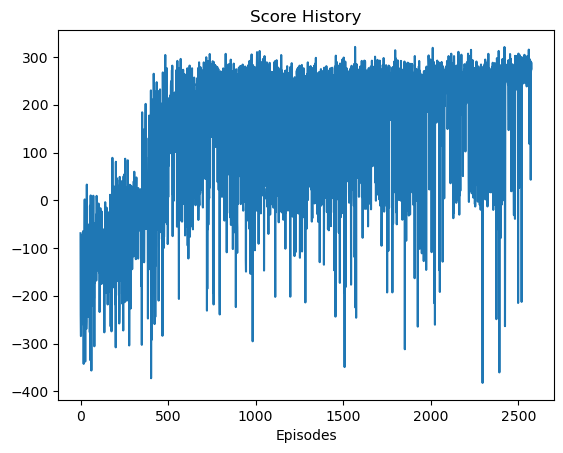

Loss,▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▇▃▁▃▂█▁▅▁▁▁▁▁▂▁▂▁▁
Score,▁▄▁▄▃▄▃▃▃▃▄▄▃▃▇▃▅▅▄▄▆▆▃▇▇▃▇▄▄▅▇▄▃▅▅█▅▅▅▄
Loss,34.66173
Score,306.6662


In [10]:
# Train the network
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset(seed=1111)
torch.manual_seed(1111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"])
plotScore(score_hist)

wandb.finish()

In [11]:
# Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="lunarLander_animation", loops=5)
env.close()

[293.726625806417, 170.63968433304566, 271.9092460746929, 194.3278768462256, 275.8490079343756, 306.7010611280572, 284.93777619858975, 244.73717250873472, 171.15194922806862, 279.9016614313198]
157.90038684961135
268.8123394500459
283.5569730600418
302.80377259566785
269.978479647432
Saving gif...Done!


![llBase](lunarLander_animation.gif)

### Run with smaller threshold for early stopping

In [18]:
# LunarLander
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-DQN-Submission",
    # Pass a run name
    name=f"DQN-LunarLander200",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "DQN",
    "dataset": "LunarLander",
    "episodes": 7000,
    "gamma": 0.99, # Discount factor
    "batch_size": 128,
    "target_score": 200, # Early stop at avg score of last 100 episodes
    "C": 5, # How often to learn
    "tau": 1e-3, # For soft update of target parameters
    "memory_size": 10000}) # Max memory buffer size

 17%|#7        | 1203/7000 [  25:15<2:01:42,  1.26s/ep, Score:  265.86, 100 score avg:  200.00]



Target Reached!


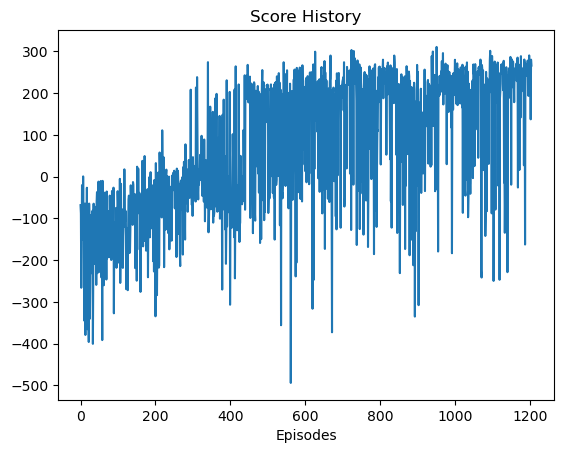

Loss,▄▄▂▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▃▁▁▁▁▁▁▆▁▁▁▁▁▄▁▇▁▄
Score,▃▂▇▄▄▃▄▄▃▄▄▆▅▅▆▄▆▄▄▄▅▃▁▄▄▅▅▄▄▇▃▄▅▅▆▃▆▇██
Loss,1.97914
Score,35.73837


In [19]:
# Train the network
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset(seed=1111)
torch.manual_seed(1111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"])
plotScore(score_hist)

wandb.finish()

In [20]:
# Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="lunarLander200_animation", loops=5)
env.close()

[280.3736173643132, 194.74629265664515, 15.915626247481882, 260.99329876602235, 268.2861883101102, 246.83308652796794, 236.8543058835758, 293.13707212962595, 262.10170834885145, 242.73039886203932]
266.6683516000987
56.88363577059978
262.45886842699525
12.946995476177918
257.2096707288616
Saving gif...Done!


![llThreshold](lunarLander200_animation.gif)

### Run with suboptimal value of gamma

In [21]:
# LunarLander
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-DQN-Submission",
    # Pass a run name
    name=f"DQN-LunarLander05",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "DQN",
    "dataset": "LunarLander",
    "episodes": 5000,
    "gamma": 0.5, # Discount factor
    "batch_size": 128,
    "target_score": 250, # Early stop at avg score of last 100 episodes
    "C": 5, # How often to learn
    "tau": 1e-3, # For soft update of target parameters
    "memory_size": 10000}) # Max memory buffer size

100%|##########| 5000/5000 [1:10:53<  00:00,  1.18ep/s, Score:  278.78, 100 score avg:  -58.29]



Done!


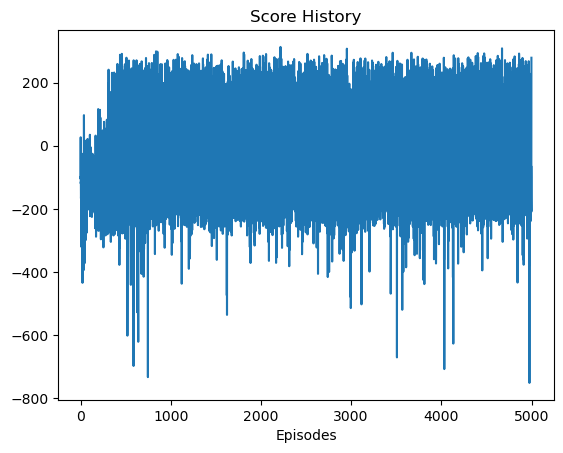

Loss,▃▂▁▁▁▁▁▁▆▁▁█▁▁▁▁▄▁▁▁▁▁▁▂▄▂▁▆▂▁▁▂▁▁▁▁▆▁▁▁
Score,▅▅▆▅▅▆▇▆█▄▆▆▆▅▆▅▁▆▅▆▇▅▆▆▅▆▆▆▅▆▅▄▆▆▆▅▆▆▆▅
Loss,2.70005
Score,-23.21091


In [22]:
# Train the network
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset(seed=1111)
torch.manual_seed(1111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"])
plotScore(score_hist)

wandb.finish()

In [23]:
# Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="lunarLander05_animation", loops=5)
env.close()

[250.15174514260178, -197.02474140850077, -172.76044123202297, 210.13668614113658, -188.68168336520725, -47.65343027057334, -32.84712732791753, -175.43967941982342, 213.80047512187883, -26.037682004494215]
262.88506116629173
-49.2176833973718
-221.8929180786268
-14.345638172706515
-197.43597294644997
Saving gif...Done!


![llGamma](lunarLander05_animation.gif)

### LunarLander DQL Considerations
Even though I collected the loss and reward data with wandb, I decided to use the score plots seen earlier to comment on the performance. This is true also for the subsequent runs with Cartpole environment. 

As we can see from the graphs, The trainings are generally very unstable, after stabilizing at acceptable values they tend to fall back. First steps always have bad rewards, but after enough steps, with the constant decay of epsilon, the agent is able to take better actions, learning from the collected transitions and improving its performances.

I chose 250 as the optimal threshold value because I found that it produces better results compared to the default threshold of 200, both in terms of landings and total reward. In fact, even though the training takes fewer episodes to complete with the threshold at 200, the results are much more unstable during testing.

Similar to policy reinforcement learning, it is confirmed here as well that a gamma value favoring future rewards leads to more stable and, above all, convergent training (with gamma at 0.5, 5000 episodes were not enough, and the results are poor).

### Deep Q-Learning runs in Cartpole environment
For the Cartpole environment, I reused the parameters established with policy reinforcement learning. There are two runs to test the best threshold value for early stopping."

 15%|#5        |  755/5000 [  01:02<  05:48, 12.17ep/s, Score:  392.00, 100 score avg:  251.13]



Target Reached!


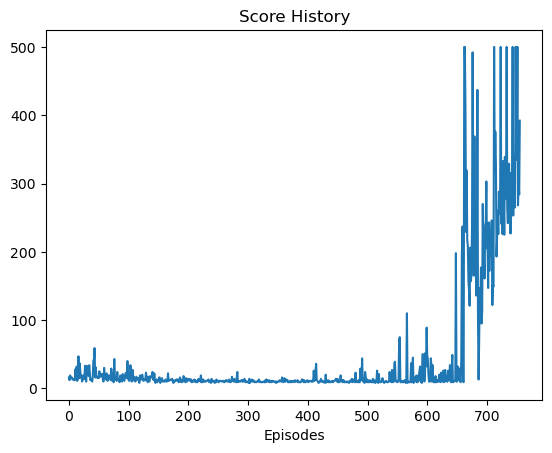

Loss,▂▁▁▁▁▂▂▂▁▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁█
Score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,0.00713
Score,128.0


[331.0, 363.0, 500.0, 321.0, 318.0, 456.0, 242.0, 494.0, 383.0, 298.0]
500.0
266.0
294.0
342.0
500.0
Saving gif...Done!


In [26]:
# Cartpole
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-DQN-Final",
    # We pass a run name (otherwise it'll be randomly assigned, like sunshine-lollypop-10)
    name=f"DQN-Cartpole",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "Cartpole",
    "dataset": "LunarLander",
    "episodes": 5000,
    "gamma": 0.99,
    "batch_size": 128,
    "target_score": 250,
    "C": 5,
    "tau": 1e-3,
    "memory_size": 10000,
    "episode_max_len": 500})

# Train the network
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset(seed=111)
torch.manual_seed(111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"],
                  max_steps=run.config["episode_max_len"])
plotScore(score_hist)

wandb.finish()

# Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="cartpole_animation", loops=5)
env.close()

### Run modifiyng threshold

100%|##########| 5000/5000 [  24:48<  00:00,  3.36ep/s, Score:  500.00, 100 score avg:  300.21]



Done!


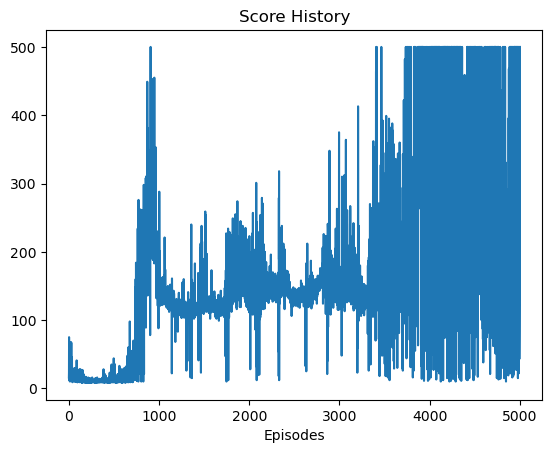

Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▂▁▁▁▁▁▁▁▂▁▃▁▂
Score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,6.24827
Score,128.0


[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
500.0
500.0
500.0
500.0
500.0
Saving gif...Done!


In [27]:
# Cartpole
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-DQN-Final",
    # We pass a run name (otherwise it'll be randomly assigned, like sunshine-lollypop-10)
    name=f"DQN-Cartpole",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "Cartpole",
    "dataset": "LunarLander",
    "episodes": 5000,
    "gamma": 0.99,
    "batch_size": 128,
    "target_score": 400,
    "C": 5,
    "tau": 1e-3,
    "memory_size": 10000,
    "episode_max_len": 500})

# Train the network
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset(seed=111)
torch.manual_seed(111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"],
                  max_steps=run.config["episode_max_len"])
plotScore(score_hist)

wandb.finish()

# Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="cartpole_animation", loops=5)
env.close()

![cartpole](cartpole_animation.gif)

### Cartpole DQL Considerations
The general considerations made about the training for the LunarLander environment also apply to this configuration.

Comparing the two runs, we might hypothesize a trade-off dependent on the early stopping threshold value. With the threshold at 250, the training ends before the maximum 5000 episodes, while with the threshold at 400, early stopping is never reached. However, the results in terms of score are better with the threshold at 400 than with 250.